## Loading libraries and setting up directories

In [8]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm
from collections import Counter
import matplotlib
import matplotlib.patheffects as PathEffects
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

from svgpathtools import parse_path



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")




In [9]:
# directory & file hierarchy
proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
features_dir= os.path.join(results_dir,'features')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))

if not os.path.exists(results_dir):
    os.makedirs(results_dir)  

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)  

if not os.path.exists(features_dir):
    os.makedirs(features_dir)
    
## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))        
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/kushin/Documents/GitHub/semantic_parts/analysis/analysis_helpers.pyc'>

## Setting up connection to mongo and creating main dataframe

In [10]:
#### set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
key  = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['semantic_parts']
coll = db['sketchpad_basic']

# which iteration name should we use?
iterationName = 'pilot0'

In [11]:
num_sketches = coll.find({'iterationName':iterationName}).count()
print 'We have {} annotations so far.'.format(num_sketches)

We have 3608 annotations so far.


In [12]:
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
kmukherjee = ['A1WU4IHJNQGVAY']
researchers = jefan + hawkrobe  + kmukherjee

In [13]:
unique_assignments = coll.find({'iterationName':iterationName}).distinct('aID')
print 'We have had {} unique sessions'.format( len(unique_assignments))

We have had 411 unique sessions


In [14]:
## get list of unique_assignments
unique_assignments = coll.find({'iterationName':iterationName}).distinct('aID')

### initialize a bunch of stuff
orig_gameID = [] # the gameID from which this sketch was sourced
outcome =[] #original outcome for that trial- true/false
orig_trial_num = [] # the trialnum in the original game from which this sketch was sourced -- 
sketch_id = [] # concatenation of orig_gameID and orig_trial_num -- 
assignmentID = [] # the session in which this annotation was collected -- 
annotation_id = [] # the unique ID for each annotation trial (different for each session the same sketch appears in)
category = [] # e.g., "chair"
target = [] # e.g., "inlay"
condition = [] # e.g., "closer" vs. "further" or "repeated" vs. "control
trial_num = [] 
workerID = [] #mTurk workerId
spline_id =[] #unique spline identifier
time_submitted = [] # when the participant clicked "next sketch"
time_labeled = [] # unique to each spline labeled
time_clicked = [] # when this spline was clicked/selected
num_strokes_in_sketch = [] # how many strokes in this sketch
num_splines_in_sketch = [] # how many spline elements in this sketch
stroke_num = [] # which stroke number this labeled spline came from
cumulative_spline_num = [] # spline index in the cumulative spline sequence for the entire sketch
within_stroke_spline_num = [] # spline index for the current stroke
cumulative_bout_num= [] #which bout of annotation the spline belonged to
part_bout_num =[] #which part-specific bout of annotation the spline belonged to
label = [] # the label provided by the participant
spline_svg_string = [] # the svg spline string that earned this label
sketch_svg_string = [] # the entire svg string correponding to this sketch
annotation_flag = [] # this is True if all splines were labeled as the same thing
annotation_spline_id = [] #unique identifier for specific annotation of a spline
png=[] #png string for the annotated sketch
stroke_id=[]
timestamp=[]

## loop through all the unique assignments that have submitted things
for this_assignment, aID in enumerate(unique_assignments):
    if this_assignment%100==0:
        print 'Analyzing sketches from assignment {} of {}  ...'.format(this_assignment, len(unique_assignments))

    ### get all the sketch recs for this assignment
    sketch_recs = coll.find({'$and': [{'iterationName':iterationName}, {'aID':aID}]}).sort('time')

    try:

        for sketch_ind,sketch in enumerate(sketch_recs):
            ## get annotations embedded within record
            sketch_cat = sketch['category']
            annotations_string = sketch['annotations']
            
    
            ## convert to json dictionary
            _annotations_dict = json.loads(annotations_string)  
           
            annotations_dict = _annotations_dict[0][sketch_cat]
            _timestamp = coll.find({'$and': [{'iterationName':iterationName}, {'aID':aID}]}).distinct('time')[sketch_ind]
            png_string = _annotations_dict[0]['png']
            num_splines = len(annotations_dict)
            for annotation in annotations_dict:
                assert sketch['numSplines']==num_splines                
                ## get spline-level metadata
            
                workerID.append(h.encode(key,sketch['wID']))
                label.append(annotation['label'])
                stroke_num.append(annotation['strokeNum'])
                spline_svg_string.append(annotation['svgString'])
                cumulative_spline_num.append(annotation['cumulativeSplineNum'])
                within_stroke_spline_num.append(annotation['withinStrokeSplineNum'])
                time_clicked.append(annotation['timeClicked'])
                time_labeled.append(annotation['timeLabeled'])
                spline_id.append('{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],annotation['cumulativeSplineNum']))
                stroke_id.append('{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],annotation['strokeNum']))
                cumulative_bout_num.append(annotation['boutNum'])
                part_bout_num.append(annotation['partBoutNum'])
                ## get sketch-level metadata
                orig_gameID.append(sketch['originalGameID'])   
                outcome.append(sketch['originalOutcome'])
                orig_trial_num.append(sketch['originalTrialNum'])
                sketch_id.append('{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum']))
                annotation_id.append('{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],sketch['aID']))
                assignmentID.append(sketch['aID'])
                category.append(sketch['category'])
                target.append(sketch['target'])
                png.append(png_string)
                timestamp.append(_timestamp)
                condition.append(sketch['condition'])
                time_submitted.append(sketch['time'])
                trial_num.append(sketch['trialNum'])
                num_splines_in_sketch.append(sketch['numSplines'])
                num_strokes_in_sketch.append(sketch['numStrokes'])
                sketch_svg_string.append(sketch['svg'])
                annotation_flag.append(sketch['sameAnnotflag'])
                annotation_spline_id.append('{}_{}_{}_{}'.format(sketch['originalGameID'],sketch['originalTrialNum'],sketch['aID'],annotation['cumulativeSplineNum']))
                
    except AssertionError:
        print 'There were unequal numbers for sketch["numSplines"] vs. num_splines for sketch {} from {}'.\
                format(sketch['trialNum'], sketch['aID'])


Analyzing sketches from assignment 0 of 411  ...
Analyzing sketches from assignment 100 of 411  ...
Analyzing sketches from assignment 200 of 411  ...
Analyzing sketches from assignment 300 of 411  ...
Analyzing sketches from assignment 400 of 411  ...


In [24]:
## make group dataframe 
D = pd.DataFrame([workerID,orig_gameID,timestamp, orig_trial_num, outcome, sketch_id, category, assignmentID,  target, \
                  annotation_id, condition, trial_num, time_submitted,\
                 time_labeled, time_clicked, num_strokes_in_sketch, num_splines_in_sketch,\
                 stroke_num, cumulative_spline_num, within_stroke_spline_num, cumulative_bout_num,\
                 part_bout_num, label, spline_svg_string, sketch_svg_string, spline_id, stroke_id,\
                  annotation_spline_id,png])
D = D.transpose()
D.columns = ['workerID','orig_gameID', 'timestamp','orig_trial_num','outcome', 'sketch_id', 'category', 'assignmentID', 'target',\
             'annotation_id', 'condition', 'trial_num', 'time_submitted',\
             'time_labeled', 'time_clicked', 'num_strokes_in_sketch', 'num_splines_in_sketch',\
             'stroke_num', 'cumulative_spline_num', 'within_stroke_spline_num', 'cumulative_bout_num', 'part_bout_num', 'label',\
             'spline_svg_string', 'sketch_svg_string', 'spline_id','stroke_id','annotation_spline_id','png']
D=D[D['assignmentID']!='']


print 'Annotations dataframe contains {} rows and {} columns.'.format(D.shape[0],D.shape[1])

Annotations dataframe contains 83474 rows and 29 columns.


In [16]:
##Check to see what dataframe looks like
D.head()

,workerID,orig_gameID,timestamp,orig_trial_num,outcome,sketch_id,category,assignmentID,target,annotation_id,...,within_stroke_spline_num,cumulative_bout_num,part_bout_num,label,spline_svg_string,sketch_svg_string,spline_id,stroke_id,annotation_spline_id,png
0,m6eRdZ3JoJehko2dkA==,4409-c993cc06-d675-4acb-881f-b5377cf24d71,1.54239e+12,1,True,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1,dog,3300DTYQT3VTI1T0Z3VDORMB3U0EQP,goldenretriever,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,...,0,0,0,leg,"M70,203c3.83938,0 19,-28.41653 19,-35","[M88,213c0,-4.76591 7.47597,-9.21395 10,-13c4....",4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_1,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_1,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,iVBORw0KGgoAAAANSUhEUgAAAUcAAAFHCAYAAAAySY5rAA...
1,m6eRdZ3JoJehko2dkA==,4409-c993cc06-d675-4acb-881f-b5377cf24d71,1.54239e+12,1,True,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1,dog,3300DTYQT3VTI1T0Z3VDORMB3U0EQP,goldenretriever,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,...,0,0,0,leg,"M88,213c0,-4.76591 7.47597,-9.21395 10,-13c4.9...","[M88,213c0,-4.76591 7.47597,-9.21395 10,-13c4....",4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_0,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_0,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,iVBORw0KGgoAAAANSUhEUgAAAUcAAAFHCAYAAAAySY5rAA...
2,m6eRdZ3JoJehko2dkA==,4409-c993cc06-d675-4acb-881f-b5377cf24d71,1.54239e+12,1,True,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1,dog,3300DTYQT3VTI1T0Z3VDORMB3U0EQP,goldenretriever,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,...,0,0,0,leg,"M169,151c13.64771,0 31,35.2618 31,48","[M88,213c0,-4.76591 7.47597,-9.21395 10,-13c4....",4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_4,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_3,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,iVBORw0KGgoAAAANSUhEUgAAAUcAAAFHCAYAAAAySY5rAA...
3,m6eRdZ3JoJehko2dkA==,4409-c993cc06-d675-4acb-881f-b5377cf24d71,1.54239e+12,1,True,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1,dog,3300DTYQT3VTI1T0Z3VDORMB3U0EQP,goldenretriever,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,...,0,0,0,leg,"M198,147c0,20.70501 25,28.72755 25,47","[M88,213c0,-4.76591 7.47597,-9.21395 10,-13c4....",4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_5,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_4,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,iVBORw0KGgoAAAANSUhEUgAAAUcAAAFHCAYAAAAySY5rAA...
4,m6eRdZ3JoJehko2dkA==,4409-c993cc06-d675-4acb-881f-b5377cf24d71,1.54239e+12,1,True,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1,dog,3300DTYQT3VTI1T0Z3VDORMB3U0EQP,goldenretriever,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,...,0,0,0,leg,"M237,172c-1.50317,0 -2,-19.96898 -2,-22","[M88,213c0,-4.76591 7.47597,-9.21395 10,-13c4....",4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_35,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_16,4409-c993cc06-d675-4acb-881f-b5377cf24d71_1_33...,iVBORw0KGgoAAAANSUhEUgAAAUcAAAFHCAYAAAAySY5rAA...


In [26]:
###Changing the NAs to "None" strings

for ind, row in D.iterrows():
    if row['label'] is None:
        row['label'] = "None"

In [27]:
##Creating a dictionary of dictionaries that maps user input labels to our main labels of interest
#Skip this cell to retain the original annotations


maplist_dict={}
maplist_dict['car'] ={'body':['body','59 decal','Body and hood','Body and windshield','Gas Cap', 'gas tank','Logo','Number','Number Decal','logo','grill',\
                'Grille','Grill','hubcap','seat','grille','ROOF','Roof','roof','number','59 decal','side mirror','Roof Panel',\
                 'Undercarriage','numbers','rearview mirror','NUMBER','Top','top','Racing Decal','Side Mirror','convertible top'],
 'bumper':['bumper','Fender','fender','fender well','front bumber','Bumper','Bumper and Hood','step'],
 'door':['door','DOOR HANDLE','door handle','handle'],
 'headlight':['headlight','taillight'],
 'hood':['hood','hood release','Hood Ornament','mirror','Mirror'],
 'trunk':['trunk','Exhaust'],
 'unknown':['Letter R','Letter e','Letter D','letter D','Says the word Drive','unknown','text','Wind','eye','Arrow','Light Beams',\
           'Light beams','Tree','hand','horn','Word',"it's just words, no picture to label",'words','Pavement','Payement'],
 'wheel':['rim','Tire','tire','wheel','wheel well','Axle','spokes','Spells the word Red','lug nuts','lug nut','rims'],
 'window':['window'],
 'windshield':['windshield','Steering wheel']
}
maplist_dict['bird']={'beak':['beak','jaw'],
                      'body':['body','chest','back','speckles','Markings','marking','markings','Marking','Coloring','coloring'],
                      'eye':['eye'],
                      'feet':['feet'],
                      'head':['head','neck','Neck','facial marking'],
                      'leg':['leg'],
                      'tail':['tail'],
                      'wing':['wing','feather','feathers','Feathers'],
                      'unknown':['unknown','B','I','R','D','This isnt a bird','not sketch','c','h',\
                                'i','r','p','Not a bird: The word "orange"','sky','Word']}
maplist_dict['dog']={'body':['body','chest','Stomach','back','butt','Butt','fur','fur ','both head and body','Back',\
                            'Belly','rear','skin fold'],
                     'ear':['ear'],
                     'eye':['eye'],
                     'head':['head','Nose','nose','Nostrils','snout','NOSE','Snout','snout area','face','mask'],
                     'leg':['leg'],
                     'mouth':['mout','tongue','muzzle','jaw','Tongue','Muzzle','chin'],
                     'neck':['neck'],
                     'paw':['paw','foot'],
                     'tail':['tail'],
                     'unknown':['unknown','Straight line in the letter "D"','Curved part of the letter "D"','left half of the letter "O"',\
                               'Right part of the letter "O"','Letter "G"','cheating','Person just wrote words','Non-Animal',\
                               'not a vaild pict of a dog','letter','W','o','f','word','letter b','Shadow','SHadow','Text',\
                               'spelling of dog','smiley face','O','F','R','K','Words "Woof Bark"','not a drawing of a dog','Word','color',\
                               'shading','writing','text']}

maplist_dict['chair']={'armrest':['armrest','sides','support slats','support slat','armrest support','decorative wood pane',\
                                 'side spindles','Chair frame','Side support','Design Elements','Leg and armrest','arm rest',\
                                 'bars','bar','arm rest support'],
                       'backrest':['backrest','headrest','Spindle','spindles','spindels','back support'],
                       'seat':['seat', 'Chair support','cushion'],
                       'leg':['leg','bottom frame','spindle','Support Bar','wheel','leg rail','leg support','support beam',\
                             'Wheel','bottom brace','stretcher','supporting wood','Leg support','top of leg','foot',\
                             'Reinforcement for legs','Brace','supports','support for legs','Bottom Support','Leg support',\
                             'Stretcher','wood beam connecting legs','Wood beam connecting legs','brace','braces','Struts','Leg Support',\
                              'metal support','support'],
                       'unknown':['unknown','frame','Descriptive label','letters','Not a chair','Frame','Decoration','Structure',\
                                 'name ','Label','Words - Bulky Garage','Part of O','letter r','Part of letter a',\
                                 'Part of letter n','Part of letter g','Part of letter e','Part of arrow',\
                                 'The word "sit"','word','text']}


In [28]:
##Actually doing the mapping
unique_cats = np.unique(D['category'])

for this_cat in unique_cats:
    maplist=maplist_dict[this_cat]
    reversed_dict = {val: key for key in maplist for val in maplist[key]}
    D.loc[D['category']==this_cat,'label']=D[D['category']==this_cat]['label'].map(reversed_dict).fillna(D['label'])

In [29]:
#Get a count of how many unique sketches have been annotated and how many unique annotations do we have in total?

unique_sketches = np.unique(D['sketch_id'].values)
print 'We have {} annotations of {} unique sketches.'.format(len(D['annotation_id'].unique()),len(unique_sketches))
 

We have 3608 annotations of 1195 unique sketches.


In [30]:
###Removing any annotations that don't have all splines annotated

for this_sketch in unique_sketches:
    DS=D[D['sketch_id']==this_sketch]
    for this_annot in np.unique(DS['annotation_id']):
        DSS= DS[DS['annotation_id']==this_annot]
        if DSS[DSS['label']== 'None'].shape[0]>0:
            D=D[D['annotation_id']!=this_annot]
        

In [31]:
##How many annotations after filtering?
len(D['annotation_id'].unique())

3319

In [32]:
##Removing any sketches that weren't annotated by at least 3 different workers
num_annots=3
for this_sketch in unique_sketches:
    DS = D[D['sketch_id']==this_sketch]
    if DS.workerID.nunique()<num_annots:
        D=D[D['sketch_id']!=this_sketch]
unique_sketches=np.unique(D.sketch_id)
    

In [33]:
##How many annotations and sketches after filtering?
print 'We now have {} annotations of {} sketches'.format(len(D['annotation_id'].unique()),len(D['sketch_id'].unique()))

We now have 2695 annotations of 864 sketches


Text(0,0.5,'number of sketches')

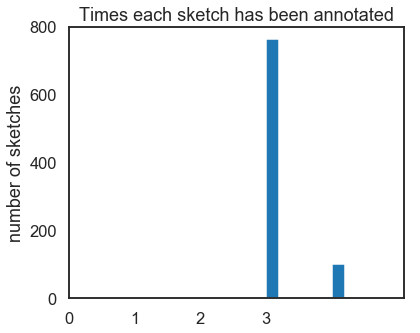

In [34]:
## get number of times each sketch has been annotated
num_times_annotated = []
for this_sketch_id in unique_sketches:
    num_times_annotated.append(D[D['sketch_id']==this_sketch_id]['assignmentID'].nunique())
    
## make a histogram
sns.set_context('talk')
plt.figure(figsize=(6,5))
h = plt.hist(num_times_annotated)
plt.xticks(np.arange(0, 4, step=1))
plt.title('Times each sketch has been annotated')
plt.ylabel('number of sketches')


In [35]:
###Subsetting for sketches that have been annotated 3 times
num_annots=3
##Why are some assignment IDs blank?
D=D[D['assignmentID']!='']
for this_sketch_id in unique_sketches:
    DS= D[D['sketch_id']==this_sketch_id]
    if DS['assignmentID'].nunique()>num_annots:
        for i in range(DS['assignmentID'].nunique()-num_annots):
            D=D.loc[D.timestamp!=DS.timestamp.min()]
            DS=DS.loc[DS.timestamp!=DS.timestamp.min()]
unique_sketches = np.unique(D['sketch_id'].values)

In [36]:
##How many sketches do we have with 3 annotations?
len(np.unique(D.sketch_id))

864

In [37]:
D.to_pickle(os.path.join(csv_dir, 'rawpckl'))

In [38]:
D=pd.read_pickle(os.path.join(csv_dir, 'rawpckl'))

## Creating spline and stroke level dataframes for further analysis

In [39]:
## get the list of unique labels applied to sketches
unique_labels = np.unique(D.label.values)

## Removing Nones and obviously wrong super long lables
unique_labels = [i for i in unique_labels if i is not None]
unique_labels = [i for i in unique_labels if len(i)<900]

print 'we have {} unique labels'.format(len( unique_labels))

we have 24 unique labels


In [40]:
##Create empty dictionary with categories as keys. We will use this to store part occurrence data for our categories
label_vect_dict = {unique_cats[0]:None,unique_cats[1]:None,unique_cats[2]:None,unique_cats[3]:None}

In [41]:
##Create vectors that contain the number of part instances in each sketch

for category in unique_cats:
    DS= D[D['category']==category]
    unique_sketches_in_cat = np.unique(DS['sketch_id'])
    unique_labels_in_cat = np.unique(DS['label'])
    ## initialize matrix that has the correct dimensions
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)), dtype=int)
    unique_labels_in_cat= np.array(unique_labels_in_cat)
    for s,this_sketch in enumerate(unique_sketches_in_cat):
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSS = DS[DS['sketch_id']==this_sketch]
        annotation_ids = np.unique(DSS['annotation_id'].values)    
        for this_annotation in annotation_ids:
            DSA = DSS[DSS['annotation_id']==this_annotation]
            label_list = DSA.label.values
            for this_label in label_list:
                label_ind = unique_labels_in_cat==this_label
                label_vec[label_ind] += 1
            
        Label_Vec[s,:]=label_vec/num_annots
    label_vect_dict[category]= Label_Vec

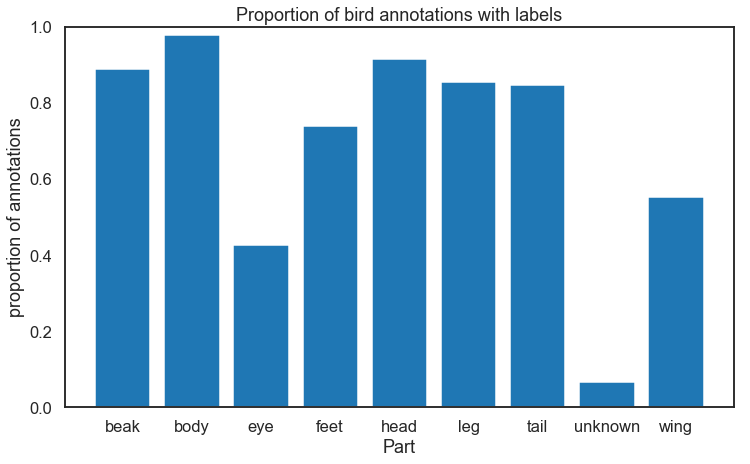

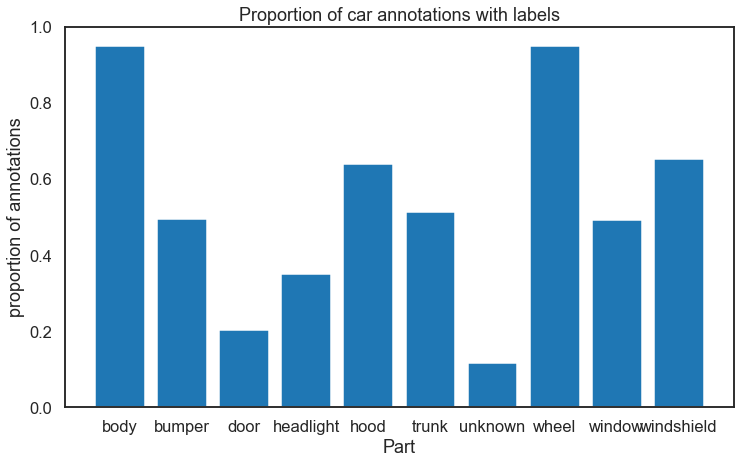

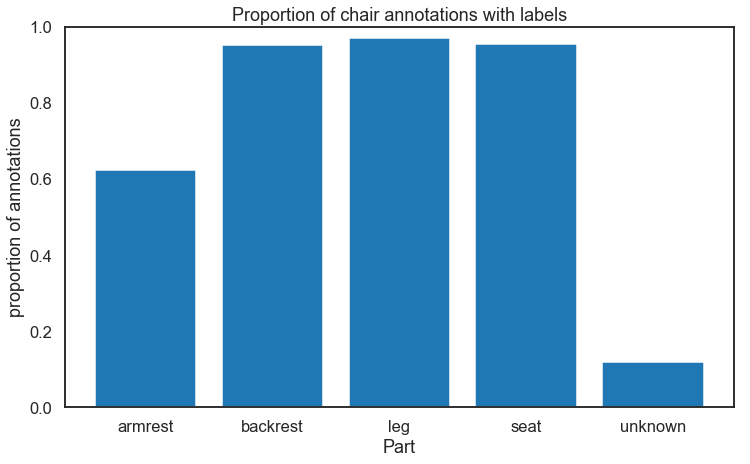

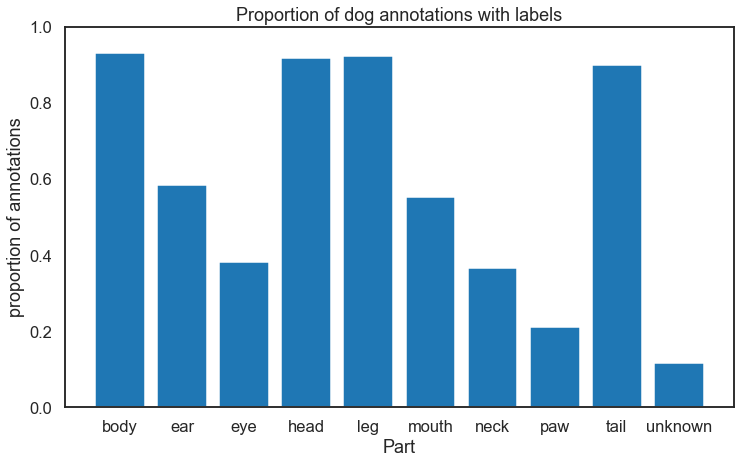

In [42]:
valid_labels=[]
valid_labels_dict={}
for category in unique_cats:
    vect = label_vect_dict[category]
    thresh = 0
    #print 'These are the labels that appear at least {} times:'.format(thresh)
    #print unique_labels[np.sum(Label_Vec,0)>thresh]
    unique_labels_in_cat = np.unique(D[D['category']==category]['label'])
    plot_labels= unique_labels_in_cat[np.sum(vect,0)>thresh]
    valid_labels_dict[category]=plot_labels
    valid_labels.append(plot_labels)


    prop_labels=[]
    for part in plot_labels:
        DS=D[D['category']==category]
        prop_labels.append(DS[DS['label']==part]['annotation_id'].nunique()/DS['annotation_id'].nunique())
    
    
    sns.set_context('talk')
    plt.figure(figsize=(12,7))
    plt.ylim(0,1)
    h = plt.bar(plot_labels,prop_labels)
    plt.title('Proportion of {} annotations with labels'.format(category))
    plt.ylabel('proportion of annotations')
    plt.xlabel('Part')
    
##flattening valid labels
valid_labels = [item for sublist in valid_labels for item in sublist]


In [43]:
#Creating a spline-level df where the modal label is set as the 'true' label for any given spline
spline_df= D.groupby('spline_id').agg(lambda x: Counter(x).most_common(1)[0][0])
spline_df.reset_index(level=0, inplace=True)

In [44]:
##Creating a stroke-level dataframe that takes the mode value of annotation for its children splines to set as its
##label value

from collections import Counter


from collections import OrderedDict
stroke_svgs=OrderedDict()
for category in unique_cats:
    DS=D[D['category']==category]
    for sketch in np.unique(DS['sketch_id']):
        DSS=DS[DS['sketch_id']==sketch]
        for stroke in np.unique(DSS['stroke_num']):
            DSA=DSS[DSS['stroke_num']==stroke]
            DSA=DSA.reset_index()
            stroke_svgs[DSA['stroke_id'][0]] = DSA['sketch_svg_string'][0][stroke]

            
            
stroke_svg_df= pd.DataFrame.from_dict(stroke_svgs, orient='index')    
stroke_group_data= D.groupby('stroke_id').agg(lambda x: Counter(x).most_common(1)[0][0])
labels= pd.DataFrame(stroke_group_data[['sketch_id','label','stroke_num','condition','target','category','outcome']])
stroke_df=pd.merge(stroke_svg_df,labels,left_index=True, right_index =True)
stroke_df.reset_index(level=0, inplace=True)
stroke_df=stroke_df.rename(index=str, columns={"index": "stroke_id", 0: "svg"})


In [45]:
##Adding total arclength information to stroke dataframe
from svgpathtools import parse_path
import svgpathtools

def calculate_arclength(svg):
    try:
        arclength= parse_path(svg).length()
    except ZeroDivisionError:
        print 'zero div error'
        arclength = 0
    return arclength
        
                    

In [ ]:
stroke_df['arc_length'] = stroke_df['svg'].apply(calculate_arclength)

## Creating feature vectors and normalizing 

In [ ]:
###This is where we make a num unique labels * 2 X number of sketches vector 

feature_vec = np.zeros((len(stroke_df.sketch_id.unique()),len(valid_labels)*2), dtype=int)
ind=0
start_pos=0
end_pos=0
meta_list=[]
cols = ['sketch_id','target','condition','category','outcome']

for cat in unique_cats:
  
    DS= stroke_df[stroke_df['category']==cat]
    unique_labels_in_cat=valid_labels_dict[cat]
    unique_sketches_in_cat=DS['sketch_id'].unique()
    start_pos = end_pos
    end_pos+= len(unique_labels_in_cat)
    print start_pos, end_pos
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)*2), dtype=int)
    arc_length_vec = np.zeros((len(unique_sketches_in_cat),len(valid_labels_dict[cat])), dtype=int)
    for s,sketch in enumerate(unique_sketches_in_cat):
        
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        arc_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSA=DS[DS['sketch_id']==sketch]
      
        meta_list.append(pd.Series([DSA['sketch_id'],DSA['target'].unique(),DSA['condition'].unique(),DSA['category'].unique(),DSA['outcome'].unique()], index=cols))
        label_list = DSA.label.values        
        for label in label_list:
            if label in unique_labels_in_cat:
                label_ind = unique_labels_in_cat==label
                label_vec[label_ind] += 1
        for label in unique_labels_in_cat:
            DSB=DSA[DSA['label']==label]
            label_ind = unique_labels_in_cat==label
            arc_vec[label_ind] = DSB['arc_length'].sum()
            
        
        feature_vec[ind,start_pos:end_pos]=label_vec
        feature_vec[ind,start_pos+len(valid_labels):end_pos+len(valid_labels)]=arc_vec
        ind+=1
feature_vec_meta = pd.DataFrame(meta_list, columns=cols)

    


    

In [ ]:
##Changing column values from np arrays to strings/boolean

def arr_to_str(arr):
    return (arr[0])
feature_vec_meta['target']=feature_vec_meta['target'].apply(arr_to_str)
feature_vec_meta['condition']=feature_vec_meta['condition'].apply(arr_to_str)
feature_vec_meta['category']=feature_vec_meta['category'].apply(arr_to_str)
feature_vec_meta['outcome']=feature_vec_meta['outcome'].apply(arr_to_str)

In [ ]:
feature_df= pd.DataFrame(feature_vec, columns=[s + '_numstrokes' for s in valid_labels]+[s + '_total_arclength' for s in valid_labels])

In [ ]:
len(np.unique(valid_labels))

In [ ]:
##creating a compressed version of the feature df with no duplicates for parts

labs_numstrokes=[]
labs_total_arclength=[]
for lab in np.unique(valid_labels):
    labs_numstrokes.append(lab +'_numstrokes')
    labs_total_arclength.append(lab+'_total_arclength')
feature_df_labs=labs_numstrokes+labs_total_arclength   
feature_df_final= pd.DataFrame(columns=feature_df_labs)


for this_lab in feature_df_labs:
    duplicates=[col for col in feature_df if col.startswith(this_lab)]
    feature_df_final[this_lab]= feature_df[duplicates].sum(axis=1)
feature_df = feature_df_final

In [ ]:
##Check to make sure the df looks okay
assert len(feature_df.columns)==len(np.unique(feature_df.columns))
feature_df.head()

In [ ]:
## Save out raw feature matrix prior to normalization within
feature_df.to_csv(os.path.join(features_dir,'semantic_parts_sketch_features_compressed_rawcounts.csv'), index=False)

In [ ]:
## Normalizing within sketch, within measure (numstrokes/arclength) 
## Note: assumes that we are using two measures and that they account for exactly half of the columns in feature_df
feature_df.iloc[:,0:int(len(feature_df.columns)/2)]=feature_df.iloc[:,0:int(len(feature_df.columns)/2)].div(feature_df.iloc[:,0:int(len(feature_df.columns)/2)].sum(axis=1),axis=0)
feature_df.iloc[:,int(len(feature_df.columns)/2):int(len(feature_df.columns))]=feature_df.iloc[:,int(len(feature_df.columns)/2):int(len(feature_df.columns))].div(feature_df.iloc[:,int(len(feature_df.columns)/2):int(len(feature_df.columns))].sum(axis=1),axis=0)

In [ ]:
### Execute this if we want to save a non-zscore matrix
run=True
if run==True:
    feature_df.to_csv(os.path.join(features_dir,'semantic_parts_sketch_features_compressed_normalized.csv'), index=False)
run=False    

In [ ]:
#z-scoring within columns

columns=list(feature_df.columns)
for this_col in columns:
    feature_df[this_col]=(feature_df[this_col] - feature_df[this_col].mean())/feature_df[this_col].std(ddof=0)


### Saving out files as needed

In [ ]:
feature_df.to_csv(os.path.join(features_dir,'semantic_parts_sketch_features_compressed_normalized_whitened.csv'), index=False)

In [ ]:
np.save(os.path.join(features_dir, 'semantic_parts_sketch_features'),feature_vec)

In [ ]:
feature_vec_meta.to_csv(os.path.join(features_dir,'semantic_parts_sketch_meta.csv'), index=False)